# Retail - Loyalty Program Analysis

### Task**:**

Analyze store loyalty program.

### Goal**:**
Evaluate the results of the loyalty program implementation, understand how the loyalty program worked, whether it is worth using it further.

### Project objectives: 
- conduct an exploratory data analysis to show the big picture;
- get the main retail metrics by cohorts from customers inside the loyalty program and outside it;
- analyze how the current loyalty program worked;
- test hypotheses;

#### Step 1. Data preparation
   - Replace column names
   - Check gaps and data types
   - Add separate date column
   - Check and remove duplicates
   - Check for abnormal values
   - Add check amount column

#### Step 2: Exploratory Data Analysis
- How many events are in the log?
- How many users are in the log?
- How many products are in the log?
- What are the most popular products?
- How many shops in dataset?
- Dynamics of sales in stores
- How many purchases per user on average?
- For what period is the data presented? Find the maximum and minimum date. Build a histogram by date and time
- define the criteria for splitting into cohorts

#### Step 3. Solving the main issues of the customer
- calculation of the main metrics: average bill, average number of purchases per user, LTV
- calculation of the main metrics in the context of stores
- calculation of the main metrics in the context of cohorts

#### Step 4. Testing statistical hypotheses
- definition and testing of two null hypotheses:
1. H0 - The average checks of clients participating and not participating in the loyalty program are equal
2. H0 - The average number of purchases per customer participating and not participating in the loyalty program are equal

#### Step 5. Conclusions for the customer
- conclusions
- recommendations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy import stats as st

#### Step 1. Data preparation

In [2]:
df = pd.read_csv('retail_dataset.csv')
prod_df = pd.read_csv('product_codes.csv')

In [3]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [4]:
prod_df = prod_df.rename(columns={'productID':'item_id'})

In [5]:
print('Number of unique products:',prod_df.item_id.nunique())
print('Total number of entries by product prices:',prod_df.item_id.count())

Number of unique products: 3159
Total number of entries by product prices: 9969


In [6]:
prod_df.duplicated().sum()

0

In [7]:
prod_df[prod_df.price_per_one == 0].count()

item_id          382
price_per_one    382
dtype: int64

In [8]:
zero_price_items = prod_df[prod_df.price_per_one == 0].item_id.unique()
prod_df[prod_df.item_id.isin(zero_price_items)].sort_values(by='item_id').groupby('item_id')\
                                     .agg({'price_per_one':['count','min', 'max', 'mean']}).price_per_one\
                                     .reset_index().sort_values(by='count', ascending=False)

,item_id,count,min,max,mean
381,POST,15,0.0,40.00,16.638000
272,79321,11,0.0,12.46,7.013636
284,84406B,10,0.0,8.29,4.253000
109,22112,9,0.0,12.72,7.543333
79,21673,9,0.0,3.36,1.812222
...,...,...,...,...,...
95,21841,1,0.0,0.00,0.000000
91,21805,1,0.0,0.00,0.000000
295,84546,1,0.0,0.00,0.000000
231,35644,1,0.0,0.00,0.000000


In [9]:
prod_df_piv = prod_df.groupby('item_id')\
                     .agg({'price_per_one':['count','min', 'max', 'mean']}).price_per_one\
                     .reset_index().sort_values(by='count', ascending=False)

prod_df_piv.head(10)
prod_df_piv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3159 entries, 3150 to 3158
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  3159 non-null   object 
 1   count    3159 non-null   int64  
 2   min      3159 non-null   float64
 3   max      3159 non-null   float64
 4   mean     3159 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 148.1+ KB


Number of unique products: 3159<br>
Total number of records for product prices: 9969<br>
Zero price for 382 items<br>
For 2419 products from the file, there are entries with different prices. There may be several reasons for this: prices have changed over time (price setting time is not given to us), an error in unloading, different prices in different stores. For the correct joining of tables and further work with them, we need to have only one price value for each product. While it is not possible to specify the reason for different prices, for the purposes of the project we will use the average price for each product.

In [10]:
prod_df_piv = prod_df_piv.loc[:,['item_id', 'mean']].rename(columns={'mean':'price_per_one'})
prod_df_piv.head(3)

,item_id,price_per_one
3150,DOT,278.734425
3151,M,253.765932
3153,S,30.125172


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [12]:
df.head(3)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0


In [13]:
df = df.rename(columns={'item_ID':'item_id', 
                        'Quantity':'quantity', 
                        'purchasedate':'purchase_date',
                        'CustomerID':'customer_id',
                        'ShopID':'shop_id',
                        'purchaseid':'purchase_id'})

In [14]:
# let's bring the "purchase_date" field to the format datetime
df.purchase_date = pd.to_datetime(df.purchase_date, format='%Y-%m-%d %H:%M:%S')

In [15]:
# add a column with a date and cast it to the type datetime64
df['date'] = pd.to_datetime(df.loc[:,('purchase_date')]).dt.normalize()

In [16]:
# cast the value of loyalty_program to integer
df.loyalty_program = df.loyalty_program.astype('int')

Check the number of duplicates and remove them

In [17]:
df.duplicated().sum()
# df[df.duplicated()==True].sort_values(by='purchase_id').head(10)

1033

In [18]:
# drop duplicates
df = df.drop_duplicates()

In [19]:
# check if users without id got into the "loyalty program"
df[df.customer_id.isnull()].groupby('loyalty_program',as_index=False).agg({'purchase_id':'count'})

,loyalty_program,purchase_id
0,0,36148


all gaps in customer_id are customers not participating in the loyalty program. There is no visible error here

In [20]:
df.describe()

,quantity,customer_id,loyalty_program
count,104302.000000,68154.000000,104302.000000
mean,7.883003,21011.165889,0.224464
std,329.565540,1766.665163,0.417231
min,-74216.000000,18025.000000,0.000000
25%,0.000000,19533.000000,0.000000
50%,2.000000,20977.000000,0.000000
75%,7.000000,22633.000000,0.000000
max,74214.000000,23962.000000,1.000000


There is a record in the dataset with a negative number of orders. Let's study them and extreme values

In [21]:
print('Quantity of records with negative order quntity:',df[df.quantity <0]['purchase_id'].count())
print('Quantity of correct orders:',df[df.quantity >0]['purchase_id'].count())
print('Sum of negative orders', df[df.quantity <0]['quantity'].sum())
print('Sum of normal orders:', df[df.quantity >0]['quantity'].sum())
print('Quantity of zero-quntity orders:', df[df.quantity == 0]['purchase_id'].count())

Quantity of records with negative order quntity: 2076
Quantity of correct orders: 69864
Sum of negative orders -119554
Sum of normal orders: 941767
Quantity of zero-quntity orders: 32362


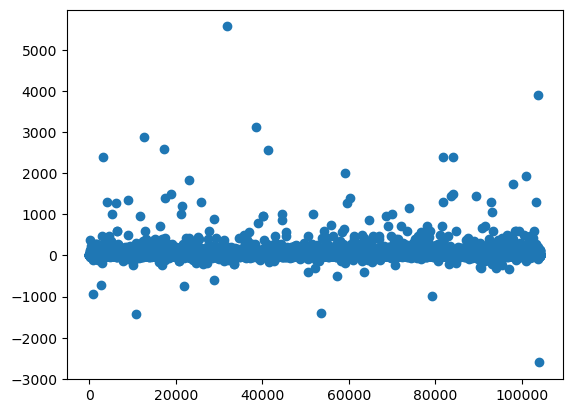

In [22]:
# check the distribution of the quantity of goods in the order, discarding the extreme values, in order to see the spread
df1 = df[df.quantity > -8000]
df1 = df1[df1.quantity < 74214]

x_values = pd.Series(range(0,len(df1)))
plt.scatter(x_values, df1['quantity']);

# sns.set(rc={'figure.figsize':(15,5)})
# sns.boxplot(data=df1, x='Quantity');

In [23]:
# check 95 and 99 percentiles
np.percentile(df.quantity, [95,99])

array([24., 99.])

In [24]:
# check 1 and 2 percentiles
np.percentile(df.quantity, [1,2])

array([-3.,  0.])

In [25]:
# check both records with extreme values of the quantity field of our dataset
df[df.quantity.isin([-74216,74214])]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
49411,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,Shop 0,0,2017-01-18
69074,541431,23166,74214,2017-01-18 10:01:00,18025.0,Shop 0,0,2017-01-18


both entries were generated on the same day with a difference of several minutes for one user. Their sequence indicates most likely an erroneous sale and its subsequent cancellation.

In [26]:
# check unique users for whom sales with a negative amount were made
neg_orders = df[df.quantity < 0]['customer_id'].unique()
neg_orders

array([20239., 23190., 19825., 22686., 20380., 18827.,    nan, 22714.,
       20779., 19359., 19978., 18150., 20285., 18089., 21337., 18162.,
       21502., 20949., 23381., 20359., 19884., 20684., 23520., 21995.,
       22774., 19983., 19477., 19351., 22380., 18151., 18532., 21193.,
       21280., 19302., 18760., 20631., 21931., 19854., 22883., 18096.,
       18326., 20388., 22225., 19541., 23529., 23924., 21392., 23047.,
       22000., 18265., 20590., 23855., 23356., 22985., 18772., 18180.,
       21387., 23090., 21249., 19372., 20367., 19278., 22764., 20529.,
       20306., 20325., 23121., 19999., 19255., 22867., 19087., 19637.,
       22178., 20322., 20900., 23720., 18391., 21475., 18113., 21052.,
       22540., 20475., 21824., 23797., 20105., 23754., 20184., 23107.,
       18238., 21870., 18729., 22396., 21214., 21543., 20894., 22986.,
       23748., 22994., 18768., 20122., 18454., 22286., 22909., 23068.,
       19835., 22607., 22409., 20970., 18794., 21560., 18092., 20990.,
      

In [27]:
# let's test our assumption about the cancellation of the sale on one more user
df[df.customer_id == 20239][df.item_id == '22776']

/var/folders/1s/1whs84ls1kz_298rcl4lgdq40000gp/T/ipykernel_41941/1758158199.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.customer_id == 20239][df.item_id == '22776']


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
64,C539944,22776,-2,2016-12-23 11:38:00,20239.0,Shop 0,0,2016-12-23
50953,539326,22776,11,2016-12-17 09:22:00,20239.0,Shop 0,0,2016-12-17
89023,542351,22776,11,2017-01-27 12:13:00,20239.0,Shop 0,0,2017-01-27


There are negative quantity values in the dataset. Apparently this is either a return or correction of an incorrectly entered order. This is also indicated by the prefix in the purchase_id of such orders<br>
Let's remove negative (2076 records) and zero (32362 records) orders from the dataset. As part of the project, we evaluate the effectiveness of the loyalty program implementation through the purchases made by different cohorts, records with zero purchases in this context are equivalent to the absence of these records<br>
We will also remove orders after that, where the number of units of production is more than 99 percentile, in order to exclude the influence of autlirs

In [28]:
df1 = df[df.quantity > 0]
np.percentile(df1.quantity, [95,99])

array([ 39., 119.])

For 99% of users, the quantity of goods in one transaction is no more than 119 units

In [29]:
df1 = df1[df1.quantity <=np.percentile(df1.quantity, 99)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69186 entries, 0 to 105334
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      69186 non-null  object        
 1   item_id          69186 non-null  object        
 2   quantity         69186 non-null  int64         
 3   purchase_date    69186 non-null  datetime64[ns]
 4   customer_id      53232 non-null  float64       
 5   shop_id          69186 non-null  object        
 6   loyalty_program  69186 non-null  int64         
 7   date             69186 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 4.8+ MB


In [30]:
# check whether for all products from the dataset there is a price per unit in the resulting file with prices
items_price = prod_df_piv.item_id.unique()
items_df = df1.item_id.unique()
no_price = []
have_price = []
for i in items_df:
    if i in items_price:
        have_price.append(i)
    else:
        no_price.append(i)
print(len(no_price))
# print(len(items_price), len(items_df))

0


In [31]:
# add to the dataset the price per unit of the product from the table 'prod_df_piv'
df1 = df1.merge(prod_df_piv, on='item_id')
df1.head(3)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69186 entries, 0 to 69185
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      69186 non-null  object        
 1   item_id          69186 non-null  object        
 2   quantity         69186 non-null  int64         
 3   purchase_date    69186 non-null  datetime64[ns]
 4   customer_id      53232 non-null  float64       
 5   shop_id          69186 non-null  object        
 6   loyalty_program  69186 non-null  int64         
 7   date             69186 non-null  datetime64[ns]
 8   price_per_one    69186 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 5.3+ MB


In [32]:
# add a field with the total amount of the check to the dataset
df1['total_amt'] = df1.apply(lambda row: row['quantity'] * row['price_per_one'], axis=1)
df1['year_month'] = df1['purchase_date'].dt.to_period('M')

df1.head(3)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one,total_amt,year_month
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,2016-12-10,1.81,19.91,2016-12
1,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0,2017-01-07,1.81,1.81,2017-01
2,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0,2017-01-18,1.81,3.62,2017-01


1. Product cost data:<br>
- Number of unique products: 3159
- Total number of records for product prices: 9969
- For 382 positions, zero price is indicated
- There are records with different prices for 2419 products from the file. There may be several reasons for this: prices have changed over time (price setting time is not given to us), an error in unloading, different prices in different stores. For the correct joining of tables and further work with them, we need to have only one price value for each product. For the purposes of the project, the average price for each product was used. The data needs clarification.
<br>
<br>
2. Sales data:<br>
- there are records with a negative number of orders in the sales dataset. Apparently this is either a return or correction of an incorrectly entered order. This is also indicated by the prefix in the purchase_id of such orders.
- for analysis, negative (2076 records) and zero (32362 records) orders were removed from the dataset. As part of the project, we evaluate the effectiveness of the loyalty program implementation through the purchases made by different cohorts, records with zero purchases in this context are equivalent to the absence of these records
- removed orders where the number of product units is more than 99 percentile (for 99% of users, the number of goods in one transaction is no more than 119 units) to eliminate the impact of outliers

#### Step 2. Exploratory Data Analysis

After the stage of data preparation from the initial dataset of 105335 records, we have 69186 records left<br>
Only for 53232 entries we have a user id

In [33]:
print('number of unique identified users:', df1.customer_id.nunique())
print('average number of completed purchases per unique user:', round(df1.customer_id.count() 
                                                                                   / df1.customer_id.nunique(),1))
print('number of unique products:', df1.item_id.nunique())
print('total shops quantity:', df1.shop_id.nunique())

number of unique identified users: 1650
average number of completed purchases per unique user: 32.3
number of unique products: 2771
total shops quantity: 31


In [34]:
# TOP-10 best-selling products (by quantity)
df1.groupby('item_id', as_index=False).agg({'quantity':'sum'}).sort_values(by='quantity', ascending=False).head(10)

,item_id,quantity
382,21212,6449
2500,85123A,5725
2482,85099B,5723
1013,22197,4161
1254,22469,3846
2321,84879,3768
1721,22961,3470
2358,84946,3255
1600,22834,3210
1153,22355,3170


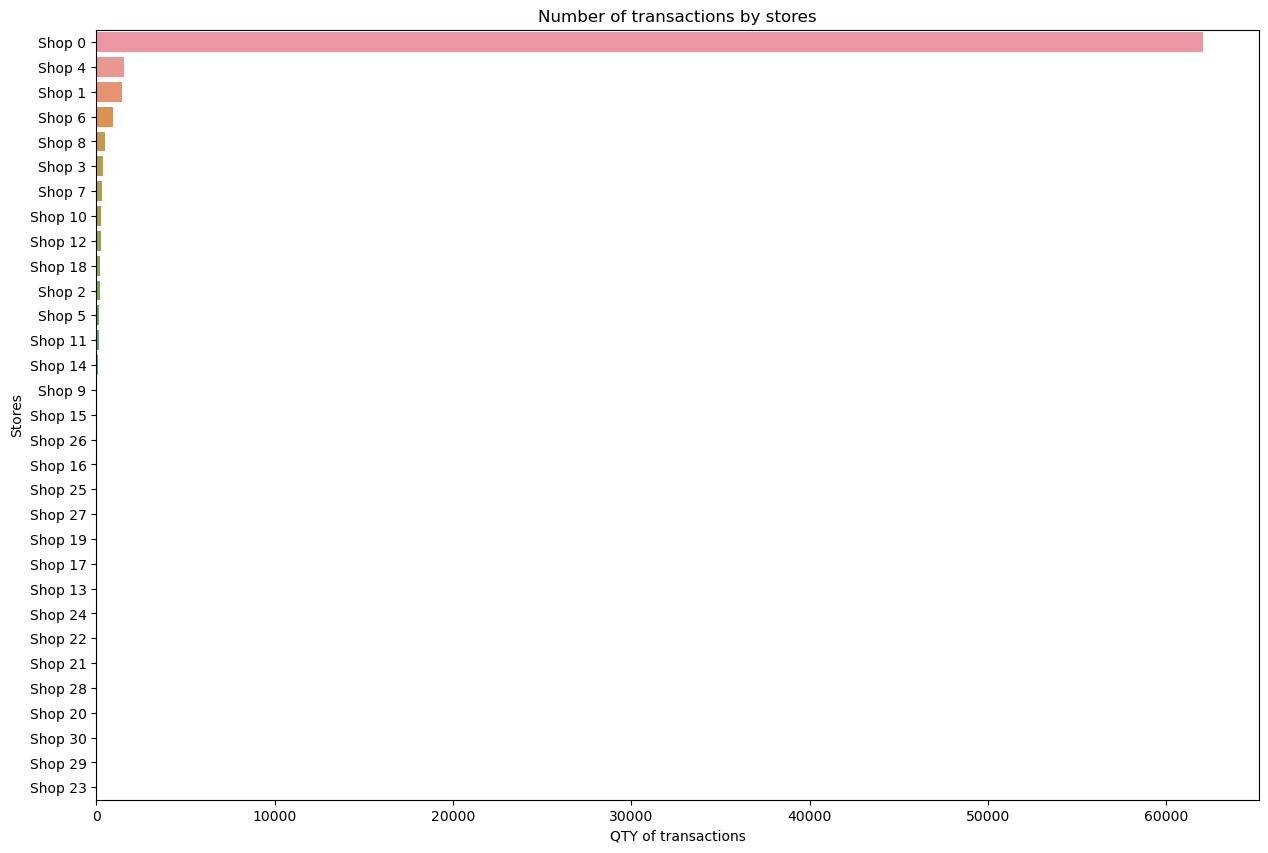

In [35]:
# number of transactions by stores
gr1 = df1.groupby('shop_id', as_index=False)\
    .agg({'quantity':'count'})\
    .sort_values(by='quantity', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(data=gr1, x='quantity', y='shop_id')
plt.title("Number of transactions by stores")
plt.xlabel('QTY of transactions')
plt.ylabel('Stores')
plt.show()

С большим отрывом лидером по количеству проведенных транзакций является Shop0

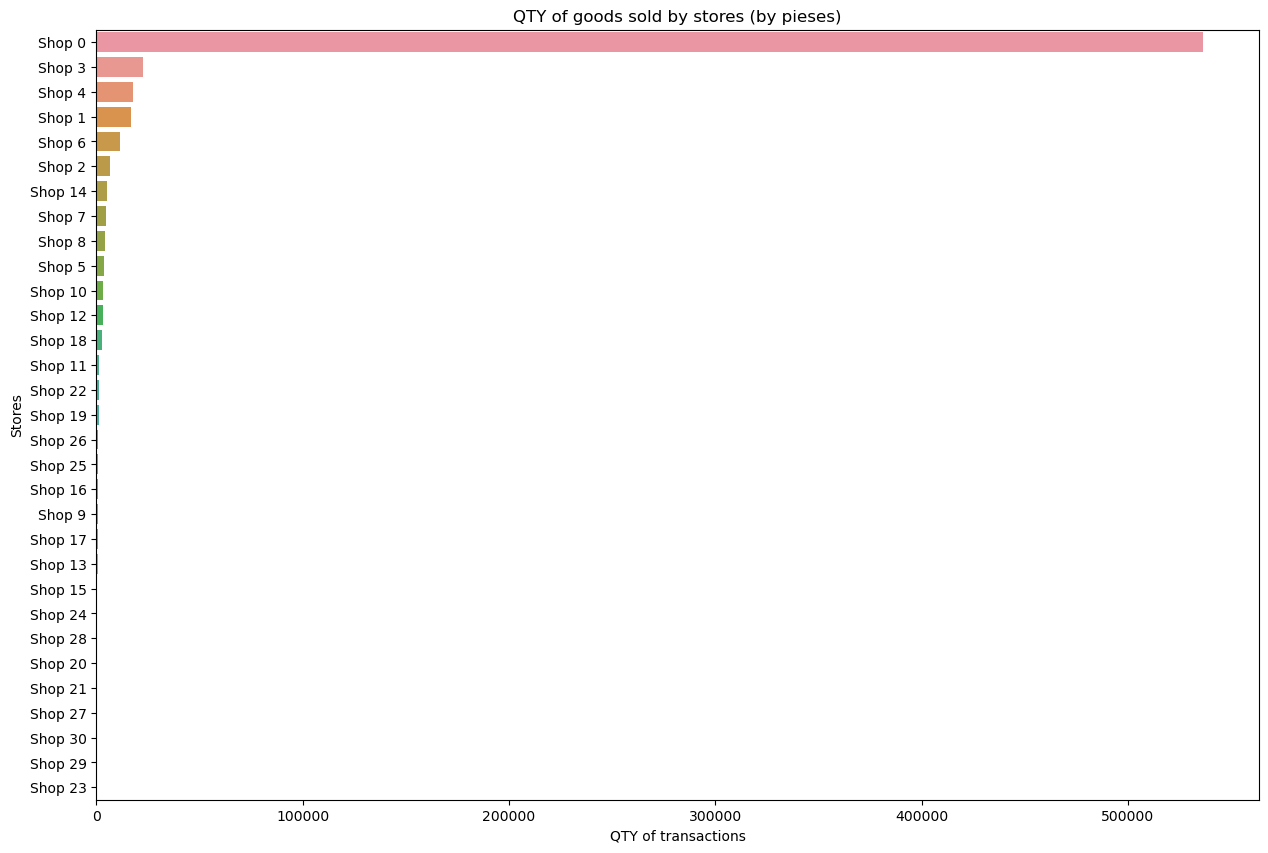

In [36]:
# number of goods sold by stores (in pieces)
gr1 = df1.groupby('shop_id', as_index=False)\
    .agg({'quantity':'sum'})\
    .sort_values(by='quantity', ascending=False)\

plt.figure(figsize=(15, 10))
sns.barplot(data=gr1, x='quantity', y='shop_id')
plt.title("QTY of goods sold by stores (by pieses)")
plt.xlabel('QTY of transactions')
plt.ylabel('Stores')
plt.show()

The leader in terms of the number of units sold is Shop0

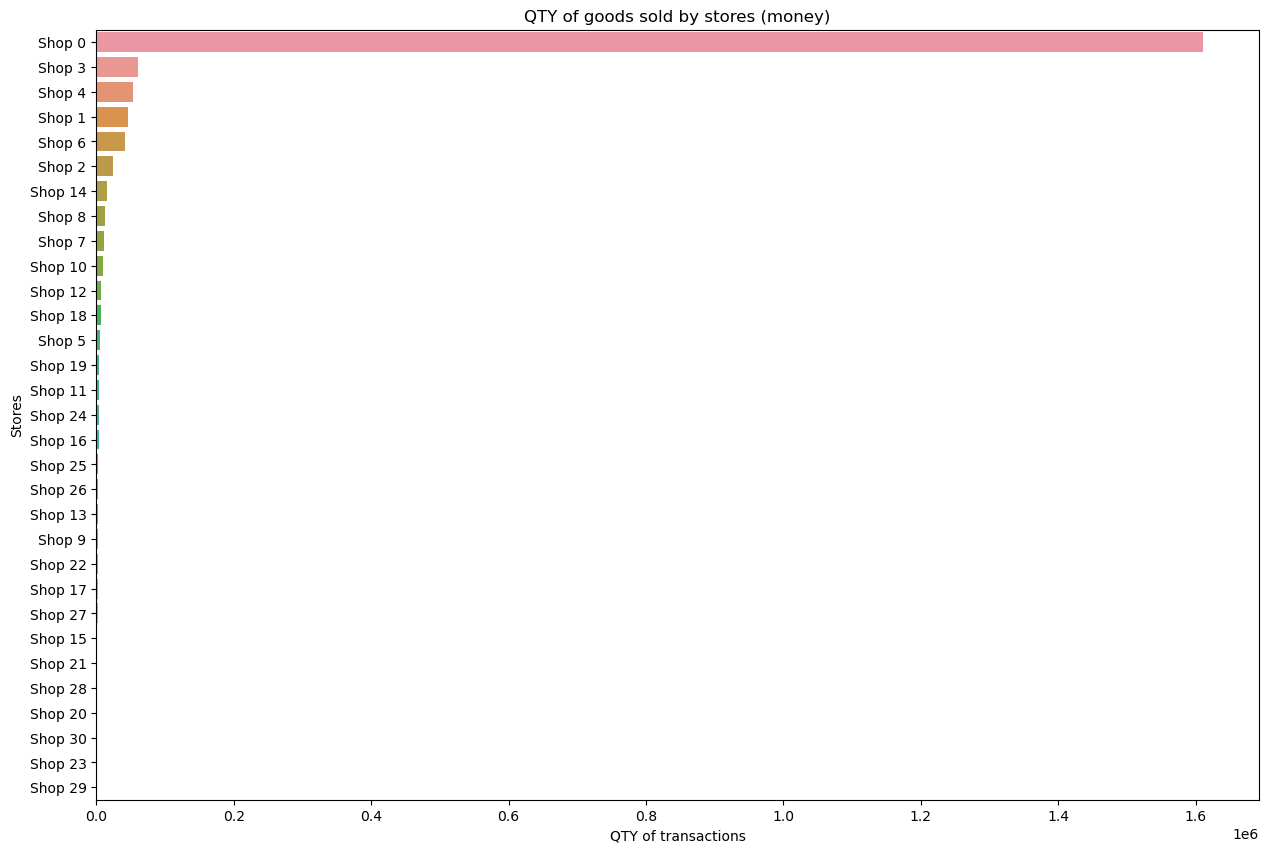

In [37]:
# number of goods sold by stores (in money)
gr1 = df1.groupby('shop_id', as_index=False)\
    .agg({'total_amt':'sum'})\
    .sort_values(by='total_amt', ascending=False)\

plt.figure(figsize=(15, 10))
sns.barplot(data=gr1, x='total_amt', y='shop_id')
plt.title("QTY of goods sold by stores (money)")
plt.xlabel('QTY of transactions')
plt.ylabel('Stores')
plt.show()

The leader in terms of the revenue is Shop0

In [38]:
df1[df1.shop_id == 'Shop 0'].total_amt.sum()/df1.total_amt.sum()

0.8274727782956615

The absolute leader in sales is Shop0 (82%)

In [39]:
print(df.date.min())
print(df.date.max())

2016-12-01 00:00:00
2017-02-28 00:00:00


The data presented in the dataset for the period from 01-12-2016 to 28-02-2017

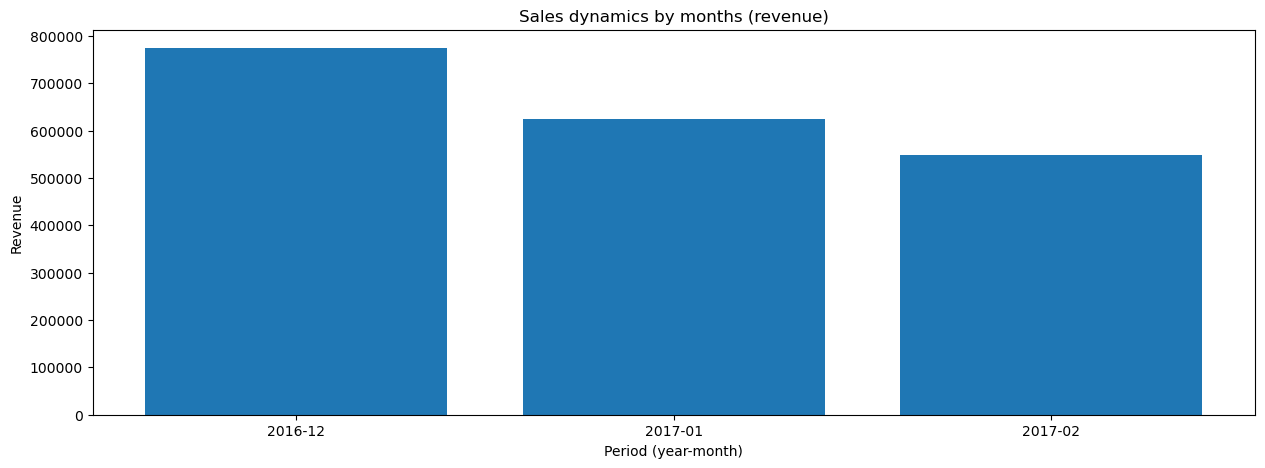

In [40]:
# sales dynamics by months (revenue)
gr = df1.groupby('year_month', as_index=False)\
    .agg({'total_amt':'sum'})
gr['year_month'] = gr['year_month'].astype('str')

plt.figure(figsize=(15, 5))
plt.bar(gr['year_month'], gr['total_amt'])
plt.title('Sales dynamics by months (revenue)')
plt.xlabel('Period (year-month)')
plt.ylabel('Revenue')
plt.show()

there is a gradual decrease in sales from month to month in the given period of time <br>
For many areas, such dynamics during these periods may be associated with seasonal fluctuations. It is possible to say more precisely only on the basis of data for these months of previous years

- The data presented in the dataset for the period from 01-12-2016 to 28-02-2017
- number of unique identified users: 1650
- average number of completed purchases per unique user: 32.3
- number of unique products purchased: 2771
- total number of stores: 31
- The absolute leader in sales is Shop_0 (82% of all sales)
- there is a gradual decrease in sales from month to month in the given period of time

#### Step 3. Solving the main issues of the customer

In [41]:
# average check, average number of purchases per user
avg1 = df1.groupby(['year_month','loyalty_program'],as_index=False)\
    .agg({'customer_id':'nunique','total_amt':'sum', 'quantity':'sum'})

In [42]:
avg1['avg_amt'] = round(avg1.total_amt / avg1.customer_id, 1)
avg1['avg_qty'] = round(avg1.quantity / avg1.customer_id, 1)
avg1

,year_month,loyalty_program,customer_id,total_amt,quantity,avg_amt,avg_qty
0,2016-12,0,551,560963.664759,182984,1018.1,332.1
1,2016-12,1,315,213316.636275,59066,677.2,187.5
2,2017-01,0,503,494526.183510,173621,983.2,345.2
3,2017-01,1,225,130363.720265,46387,579.4,206.2
4,2017-02,0,488,396511.918329,135159,812.5,277.0
5,2017-02,1,250,151737.278473,53375,606.9,213.5


Due to the significant concentration of sales in one store (Shop0), the calculation of metrics for stores will not give us any results for subsequent conclusions

For splitting by cohorts, let's take the first purchase by a user in a certain month as a common event. Sign to split the presence or absence of registration in the loyalty program

In [43]:
df1.head(3)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one,total_amt,year_month
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,2016-12-10,1.81,19.91,2016-12
1,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0,2017-01-07,1.81,1.81,2017-01
2,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0,2017-01-18,1.81,3.62,2017-01


In [44]:
# find users who were not registered in the program at the beginning, and then registered
qq = df1.groupby(['customer_id']).agg({'loyalty_program':'mean'}).reset_index()
qq = qq[qq.loyalty_program < 1]
qq[qq.loyalty_program > 0]
# there are no such users

,customer_id,loyalty_program


In [45]:
# the function generates customer profiles for which we can further conduct cohort analysis and test hypotheses
def get_profiles(df):

    profiles = (
        df.sort_values(by=['customer_id', 'purchase_date'])
        .groupby('customer_id')
        .agg(
            {
                'purchase_date': 'first',
                'quantity': 'sum',
                'purchase_id': 'count',
                'loyalty_program': 'first',
                'total_amt' : 'sum',
                'year_month' : 'first',
            }
        )
        .rename(columns={'purchase_id': 'purchases'})
        .reset_index()
    )

    return profiles

In [46]:
profiles = get_profiles(df1)
profiles['avg_bill'] = profiles.total_amt / profiles.purchases

In [47]:
profiles.head(10)

,customer_id,purchase_date,quantity,purchases,loyalty_program,total_amt,year_month,avg_bill
0,18026.0,2016-12-07 14:57:00,574,60,0,1718.362024,2016-12,28.639367
1,18027.0,2016-12-16 19:09:00,974,16,0,1311.263286,2016-12,81.953955
2,18029.0,2017-02-02 16:01:00,180,16,0,385.261000,2017-02,24.078812
3,18031.0,2017-02-16 12:33:00,83,15,0,370.659667,2017-02,24.710644
4,18035.0,2017-01-18 09:50:00,1180,36,0,3614.032738,2017-01,100.389798
5,18038.0,2017-01-12 12:43:00,513,88,0,1947.140071,2017-01,22.126592
6,18040.0,2017-02-25 13:51:00,81,9,0,260.897000,2017-02,28.988556
7,18041.0,2017-02-17 10:30:00,202,27,0,592.739071,2017-02,21.953299
8,18044.0,2017-02-21 13:51:00,152,20,0,402.710000,2017-02,20.135500
9,18049.0,2016-12-14 12:58:00,877,68,0,2198.817345,2016-12,32.335549


In [48]:
profiles.total_amt.sum()

1753397.9912194402

In [49]:
df1.total_amt.sum()

1947419.4016116003

when splitting into cohorts, were ignored records that don't contain customer_id

We can see the dynamics of LTV only by user cohorts of the first period

In [50]:
# Users of first period
ltv_prof = profiles[profiles.year_month == '2016-12'][['customer_id', 'loyalty_program']]\
        .merge(df1[['customer_id', 'total_amt', 'year_month']],on='customer_id', how='left')

ltv_prof.groupby(['year_month', 'loyalty_program'], as_index=False)\
        .agg({'total_amt':'sum'})
ltv_prof.pivot_table(index='loyalty_program', columns='year_month', aggfunc={'total_amt':'sum'})\
        .reset_index().total_amt.rename(columns={'year_month':'loyalty_program'})

year_month,2016-12,2017-01,2017-02
0,461908.794980,239397.115918,184637.997476
1,213316.636275,76030.127008,73622.439065


In [51]:
ltv_prof.groupby(['year_month', 'loyalty_program'],as_index=False).agg({'total_amt':'sum'})

,year_month,loyalty_program,total_amt
0,2016-12,0,461908.794980
1,2016-12,1,213316.636275
2,2017-01,0,239397.115918
3,2017-01,1,76030.127008
4,2017-02,0,184637.997476
5,2017-02,1,73622.439065


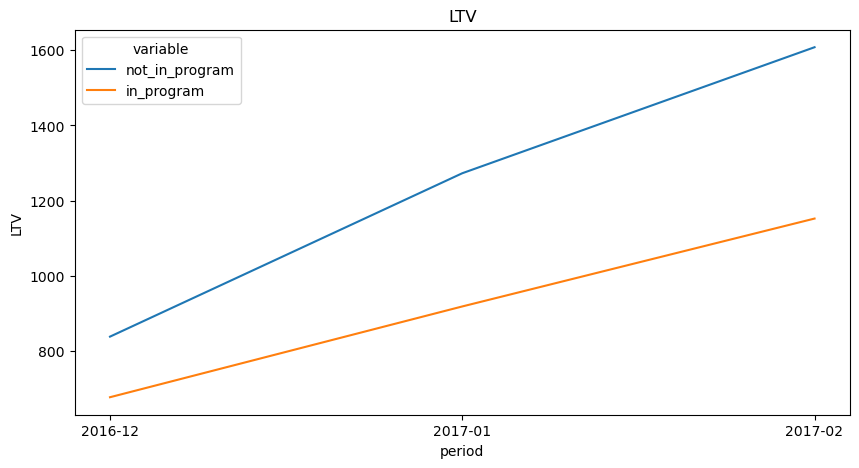

In [52]:
ltv = ltv_prof.pivot_table(index='loyalty_program', columns='year_month', aggfunc={'total_amt':'sum'})\
        .reset_index().total_amt.rename(columns={'year_month':'loyalty_program'}).cumsum(axis=1).T

ltv = ltv.reset_index().rename(columns={0: 'not_in_program', 1:'in_program'})
ltv.not_in_program = ltv.not_in_program / ltv_prof[ltv_prof.loyalty_program == 0].customer_id.nunique()
ltv.in_program = ltv.in_program / ltv_prof[ltv_prof.loyalty_program == 1].customer_id.nunique()

# ltv['year_month'] = pd.to_datetime(ltv['year_month'])
ltv['year_month'] = ltv['year_month'].astype('str')
# ltv['year_month'] = pd.to_datetime(ltv['year_month'], format='%Y-%m')
# ltv['year_month'] = ltv['year_month'].to_timestamp

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x='year_month', y='value', hue='variable', 
             data=pd.melt(ltv, ['year_month']))
plt.title('LTV')
plt.ylabel('LTV')
plt.xlabel('period')
plt.show()


LTV for customers registered in the loyalty program is lower than for non-registered customers, and its growth rate is slower

In [53]:

profiles.groupby(['year_month', 'loyalty_program'])\
        .agg({'customer_id':'count', 'total_amt':'mean', 'purchases': 'mean'})\
        .reset_index()\
        .rename(columns={'customer_id':'customers',
                         'total_amt' : 'avg_amt_by_cust',
                         'purchases' : 'avg_purh_by_cust'})

,year_month,loyalty_program,customers,avg_amt_by_cust,avg_purh_by_cust
0,2016-12,0,551,1607.883681,42.983666
1,2016-12,1,315,1152.283182,36.009524
2,2017-01,0,293,797.322339,25.542662
3,2017-01,1,121,550.565157,26.305785
4,2017-02,0,254,544.964576,19.188976
5,2017-02,1,116,567.500420,22.965517


Using the table above, we can estimate the size of the resulting cohorts and the average values of key indicators for them (average check per client and average number of purchases per client)<br>
For the first two months of the dataset, the average check value for a client not registered in the loyalty program is higher. For the third month, this figure is slightly higher for the group of registered users <br>
The loyalty program does not look successful in terms of average check per user. <br>
The average number of purchases per user in the first month is higher for non-registered users. For the second and third months, the average number of purchases for users registered in the loyalty program is slightly higher than for non-registered users.<br>
Let's check whether these discrepancies are statistically significant.

#### Step 4. Testing statistical hypotheses

H0 - The average checks of clients participating and not participating in the loyalty program are equal<br>
H1 - Average checks of clients participating and not participating in the loyalty program are not equal

In [54]:
# function for testing hypotheses
def hip_check (profiles, period, avg_parametr, alpha):
    profile = profiles[profiles.year_month == period]

    profile1 = profile[profile.loyalty_program == 0][avg_parametr]
    profile2 = profile[profile.loyalty_program == 1][avg_parametr]

    results = st.mannwhitneyu(profile1, profile2)
    
    if results.pvalue < alpha:
        message = 'We reject the null hypothesis: the difference is statistically significant'
    else:
        message = 'Cannot reject null hypothesis, no difference can be drawn'
            
    
    return print('p-value: ', results.pvalue,'\n',message)

In [55]:
hip_check(profiles, '2016-12', 'avg_bill', 0.05)

p-value:  0.001872878492130218 
 We reject the null hypothesis: the difference is statistically significant


In [56]:
hip_check(profiles, '2017-01', 'avg_bill', 0.05)

p-value:  0.040801497913321765 
 We reject the null hypothesis: the difference is statistically significant


In [57]:
hip_check(profiles, '2017-02', 'avg_bill', 0.05)

p-value:  0.38909987659984824 
 Cannot reject null hypothesis, no difference can be drawn


Only for groups of the third month from our observations, we cannot reject the hypothesis about the difference in average bills<br>
For cohorts of the first and second months, the difference between the average check of the two groups is statistically significant<br>
For the first and second cohorts, users not registered in the loyalty program give a higher average check than non-registered users. For the third cohort, the previously obtained differences are not significant.<br>
The loyalty program for this indicator shows its inefficiency on three cohorts

let's check the second hypothesis:<br>
H0 - The average number of purchases per customer participating and non-participating in the loyalty program are equal<br>
H1 - The average number of purchases per customers participating and not participating in the loyalty program are not equal

In [58]:
hip_check(profiles, '2016-12', 'purchases', 0.05)

p-value:  0.6462640394809156 
 Cannot reject null hypothesis, no difference can be drawn


In [59]:
hip_check(profiles, '2017-01', 'purchases', 0.05)

p-value:  0.6570273775899758 
 Cannot reject null hypothesis, no difference can be drawn


In [60]:
hip_check(profiles, '2017-02', 'purchases', 0.05)

p-value:  0.28898688037515496 
 Cannot reject null hypothesis, no difference can be drawn


For all cohorts, it is impossible to draw a conclusion about the difference in the average number of purchases between customers participating and not participating in the loyalty program<br>
There is no difference between the two user groups for this indicator.

In [61]:
# a function to test the hypothesis over the entire dataset
def hip_check2 (profiles, avg_parametr, alpha):
    profile = profiles

    profile1 = profile[profile.loyalty_program == 0][avg_parametr]
    profile2 = profile[profile.loyalty_program == 1][avg_parametr]

    results = st.mannwhitneyu(profile1, profile2)
    
    if results.pvalue < alpha:
        message = 'We reject the null hypothesis: the difference is statistically significant'
    else:
        message = 'Cannot reject null hypothesis, no difference can be drawn'
            
    
    return print('p-value: ', results.pvalue,'\n',message)

In [62]:
# hip_check2(profiles, 'purchases', 0.05)

In [63]:
# hip_check2(profiles, 'avg_bill', 0.05)

In [64]:
# hip_check2(profiles, 'total_amt', 0.05)

With 95% certainty, we can draw the following conclusions:<br>
In terms of the average check per user, the loyalty program showed its inefficiency<br>
There is no difference between the two groups in terms of average purchases per user

### Step 5. Conclusions and recommendations

#### Step 5.1. Conclusions:
**Analysis of the provided data:**<br>
1. Product cost data:<br>
- Number of unique products: 3159
- Total number of records for product prices: 9969
- For 382 positions, zero price is indicated
- There are records with different prices for 2419 products from the file. There may be several reasons for this: prices have changed over time (price setting time is not given to us), an error in unloading, different prices in different stores. For the correct joining of tables and further work with them, we need to have only one price value for each product. For the purposes of the project, the average price for each product was used. The data needs clarification.
<br>
<br>
2. Sales data:<br>
- there are records with a negative number of orders in the sales dataset. Apparently this is either a return or correction of an incorrectly entered order. This is also indicated by the prefix in the purchase_id of such orders.
- for analysis, negative (2076 records) and zero (32362 records) orders were removed from the dataset. As part of the project, we evaluate the effectiveness of the loyalty program implementation through the purchases made by different cohorts, records with zero purchases in this context are equivalent to the absence of these records
- we removed orders where the number of product units is more than 99 percentile (for 99% of users, the number of goods in one transaction is no more than 119 units) to eliminate the impact of emissions
- number of unique identified users: 1650
- average number of completed purchases per unique user: 32.3
- number of unique products purchased: 2771
- total number of stores: 31
- The absolute leader in sales is Shop_0 (82% of all sales)
<br>

**Loyalty program analysis:**<br>
For splitting into cohorts, the first purchase made by a user in a certain month was taken as a common event. Sign to split the presence or absence of registration in the loyalty program

LTV for customers registered in the loyalty program is lower than for non-registered customers, and its growth rate is slower<br>
For the first two months of the dataset, the average check value for a client not registered in the loyalty program is higher. For the third month, this figure is slightly higher for the group of registered users <br>
The loyalty program does not look successful in terms of average check per user. <br>
The average number of purchases per user in the first month is higher for non-registered users. For the second and third months, the average number of purchases for users registered in the loyalty program is slightly higher than for non-registered users.<br>
Let's check whether these discrepancies are statistically significant.

**Hypothesis testing:**<br>
first hypothesis:<br>
H0 - The average checks of clients participating and not participating in the loyalty program are equal<br>
H1 - The average checks of clients participating and not participating in the loyalty program are not equal<br>
Only for the cohorts of the third month from our observations, we cannot reject the hypothesis about the difference in average bills<br>
For the cohorts of the first and second months, the difference between the average checks of the two groups is statistically significant<br>
For the first and second cohorts, users not registered in the loyalty program give a higher average check than non-registered users. For the third cohort, the previously obtained differences are not significant.<br>
The loyalty program for this indicator shows its inefficiency on three cohorts

second hypothesis:<br>
H0 - The average number of purchases per customer participating and non-participating in the loyalty program are equal<br>
H1 - The average number of purchases per customer participating and non-participating in the loyalty program are not equal<br>
For all cohorts, a conclusion about the difference in the average number of purchases between customers participating and not participating in the loyalty program cannot be made. There is no difference between the two user groups for this indicator.

According to the results of the first two months, the loyalty program did not show effectiveness in terms of the average check per customer (average checks for unregistered users are higher). Clients who came in the third month at a significance level of 5% show comparable results<br>

The loyalty program for the two selected parameters showed its inefficiency.

#### Step 5.2. Recommendations:
1. Stop connecting new users to the loyalty program in its current form
2. Rethink the loyalty program

In [65]:
df1.to_csv('new_retail_dataset.csv', index = False, sep = '\t')